# Perceptron Algorithm and Fisher's Discriminant

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal as normal
from scipy.linalg import pinv as inv

cor = ['#fad390', '#f6b93b', '#fa983a', '#e58e26', '#f8c291', '#e55039', '#eb2f06', '#b71540']
cog = ['#b8e994', '#78e08f', '#38ada9', '#079992']
cob = ['#6a89cc', '#4a69bd', '#1e3799', '#0c2461', '#82ccdd', '#60a3bc', '#3c6382', '#0a3d62']

---
##### Summary
* Goal: Implement Rosenblatt's Perceptron algorithm and Fisher's linear Discriminant.
* Methods:
    1. Generate an non-linearly separable "double moon" dataset.
    2. Compare performance by projecting datapoints onto the boundary and looking at the classification error overlap.
* Details:
    1. Bishop, PRML, Chapter 4.
    2. [Perceptron (Wikipedia)](https://en.wikipedia.org/wiki/Perceptron).
___


Perceptron: 38 misclassified points after 20 iterations
Fisher crit: 23 misclassified points, J_w = 0.04


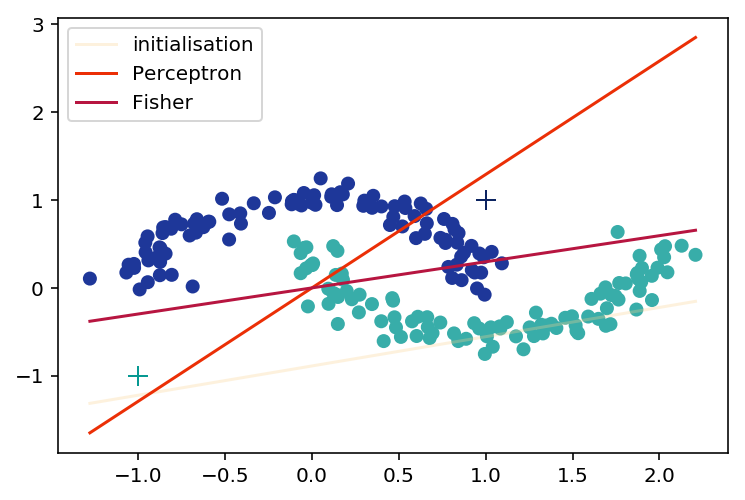

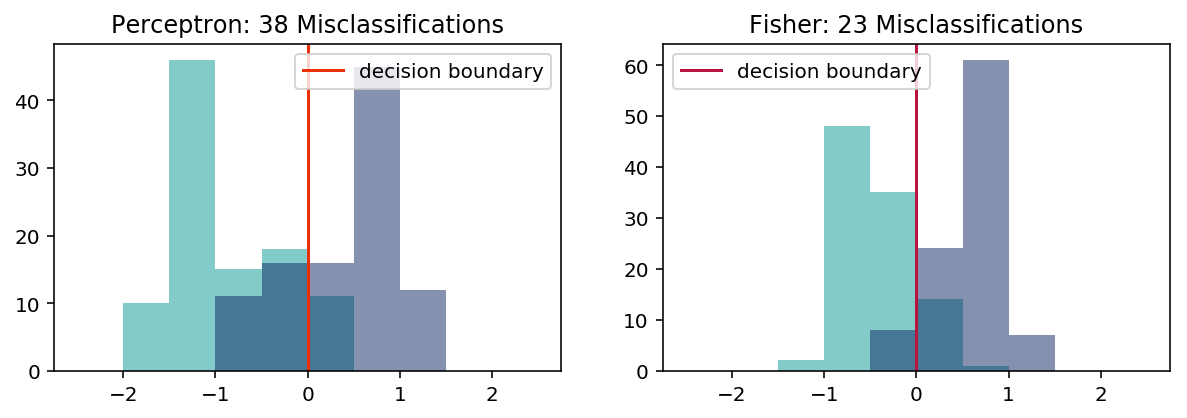

In [34]:
# Generate double moon dataset
n, noise = 100, 0.1
outer_circ_x = np.cos(np.linspace(0, np.pi, n))
outer_circ_y = np.sin(np.linspace(0, np.pi, n))
inner_circ_x = 1 - np.cos(np.linspace(0, np.pi, n))
inner_circ_y = 1 - np.sin(np.linspace(0, np.pi, n)) - .5

D = np.vstack((np.append(outer_circ_x, inner_circ_x),
               np.append(outer_circ_y, inner_circ_y))).T
t = np.hstack([-np.ones(n, dtype=np.intp),
               np.ones(n, dtype=np.intp)])
D += np.random.normal(scale=noise, size=D.shape)
D = np.concatenate((D, t[:,None]), axis=1)
np.random.shuffle(D)
x, y, t = D[:,0], D[:,1], D[:,2]
x_space = np.linspace(np.min(x),np.max(x),2)
plt.scatter(x,y, c=[cog[2] if x == 1 else cob[2] for x in t])

# init w
w = np.array([0.8, -0.3, 0.9])

def boundary(w, x):
    return -w[1]/w[2]*x - w[0]/w[2]

y_pred = boundary(w,x_space)
plt.plot(x_space, y_pred, color=cor[0], label='initialisation', alpha=0.3)
#plt.plot(*dist1.mean, '+', color= cog[3], ms=10)
#plt.plot(*dist2.mean, '+', color= cob[3], ms=10)

# Perceptron Algorithm
iterations = 20
for j in range(iterations):
    for idx in range(2*n):
        phi_n = np.array([1, x[idx], y[idx]])
        tn = t[idx]
        w -= phi_n*tn

y_pred = boundary(w,x_space)
plt.plot(x_space, y_pred, color=cor[-2], label='Perceptron')

def append_one(x): return np.concatenate((np.ones((x.shape[0],1)), x), axis=1)

errors =  append_one(D[:,:2]) @ w
errors = [1 if i > 0 else -1 for i in errors]
n_errors = np.sum(np.abs(errors + t)/2)
print('Perceptron: {:d} misclassified points after {:d} iterations'.format(int(n_errors), iterations))


# Fisher's Linear Discriminant
c1 = D[D[:,2]==1][:,:2]
c2 = D[D[:,2]==-1][:,:2]

c1 = append_one(c1)
c2 = append_one(c2)

m1 = np.sum(c1, axis=0)/c1.shape[0]
m2 = np.sum(c2, axis=0)/c2.shape[0]

Sb = (m1-m2)[:,None] @ (m1-m2)[None,:]         # between class variance
Sw = (c1-m1).T @ (c1-m1) + (c2-m2).T @ (c2-m2) # within class variance

w_fisher = inv(Sw) @ (m2-m1)
plt.plot(x_space, boundary(w_fisher, x_space), color=cor[-1], label='Fisher')
plt.legend(loc=0)

errors_fisher =  append_one(D[:,:2]) @ w_fisher
errors_fisher = [1 if i > 0 else -1 for i in errors_fisher]
n_errors_fisher = np.sum(np.abs(errors_fisher + t)/2)

wu_fisher = w_fisher/np.linalg.norm(w_fisher)
Jw = (wu_fisher @ Sb @ wu_fisher) / (wu_fisher @ Sw @ wu_fisher)

print('Fisher crit: {:d} misclassified points, J_w = {:.2f}'.format(int(n_errors_fisher), Jw))

# Projections on w
plt.figure(figsize=(10,3))
plt.subplot(121)
plt.title('Perceptron: {} Misclassifications'.format(int(n_errors)))
wu = w/np.linalg.norm(w)
proj = append_one(D[:,:2]) @ wu
bins = np.arange(-2.5,2.6,0.5)
plt.hist(proj[t==1], bins, color=cog[3], alpha=0.5)
plt.hist(proj[t==-1], bins, color=cob[3], alpha=0.5)
plt.axvline(0, color=cor[-2],label='decision boundary')
plt.legend(loc=0)

plt.subplot(122)
plt.title('Fisher: {} Misclassifications'.format(int(n_errors_fisher)))
proj = append_one(D[:,:2]) @ wu_fisher
bins = np.arange(-2.5,2.6,0.5)
plt.hist(proj[t==1], bins, color=cog[3], alpha=0.5)
plt.hist(proj[t==-1], bins, color=cob[3], alpha=0.5);
plt.axvline(0, color=cor[-1], label='decision boundary')
plt.legend(loc=0);